In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pickle
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nLibraries imported successfully!")

Using device: cuda
GPU: Tesla T4

Libraries imported successfully!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/Shut up/processing/cleaned_label.csv'

In [5]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nFirst few rows:")
print(df.head())

Loading dataset...
Dataset shape: (50000, 2)

Columns: ['review_text', 'sentiment_label']

Sentiment distribution:
sentiment_label
0    25000
1    25000
Name: count, dtype: int64

First few rows:
                                         review_text  sentiment_label
0  Once again Mr. Costner has dragged out a movie...                0
1  This is a pale imitation of 'Officer and a Gen...                0
2  Years ago, when DARLING LILI played on TV, it ...                0
3  I was looking forward to this movie. Trustwort...                0
4  First of all, I would like to say that I am a ...                0


In [6]:
# Model name - SBERT all-MiniLM-L6-v2
MODEL_NAME = 'all-MiniLM-L6-v2'

print(f"Loading SBERT model: {MODEL_NAME}")
print("Note: SBERT (Sentence-BERT) is optimized for sentence embeddings")
print("      - Uses siamese/triplet networks")
print("      - Produces semantically meaningful embeddings")
print("      - Faster than BERT for similarity tasks")
print("      - Only 22M parameters (very efficient!)\n")

# Load model
model = SentenceTransformer(MODEL_NAME)
model = model.to(device)

print(f"Model loaded successfully!")
print(f"Max sequence length: {model.max_seq_length}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"Number of parameters: ~22M (6 layers, 384 hidden size)")

Loading SBERT model: all-MiniLM-L6-v2
Note: SBERT (Sentence-BERT) is optimized for sentence embeddings
      - Uses siamese/triplet networks
      - Produces semantically meaningful embeddings
      - Faster than BERT for similarity tasks
      - Only 22M parameters (very efficient!)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded successfully!
Max sequence length: 256
Embedding dimension: 384
Number of parameters: ~22M (6 layers, 384 hidden size)


In [7]:
def get_sbert_embedding(text, model):
    """
    Extract SBERT sentence embedding

    Args:
        text: str - Input text
        model: SentenceTransformer model

    Returns:
        numpy array: 384-dimensional embedding vector
    """
    # SBERT handles everything internally (tokenization, pooling, etc.)
    embedding = model.encode(text, convert_to_numpy=True, show_progress_bar=False)
    return embedding

print("Embedding extraction function defined!")

# Test on sample texts
sample_texts = [
    "This movie is absolutely fantastic!",
    "This film is really great!",
    "Terrible movie, waste of time."
]

print("\nTesting with sample texts:")
embeddings_test = []
for text in sample_texts:
    emb = get_sbert_embedding(text, model)
    embeddings_test.append(emb)
    print(f"  '{text}' -> shape: {emb.shape}")

# Check similarity between similar and different sentences
from sklearn.metrics.pairwise import cosine_similarity
sim_similar = cosine_similarity([embeddings_test[0]], [embeddings_test[1]])[0][0]
sim_different = cosine_similarity([embeddings_test[0]], [embeddings_test[2]])[0][0]

print(f"\nSimilarity (fantastic vs great): {sim_similar:.4f}")
print(f"Similarity (fantastic vs terrible): {sim_different:.4f}")
print("Note: SBERT captures semantic similarity!")

Embedding extraction function defined!

Testing with sample texts:
  'This movie is absolutely fantastic!' -> shape: (384,)
  'This film is really great!' -> shape: (384,)
  'Terrible movie, waste of time.' -> shape: (384,)

Similarity (fantastic vs great): 0.8600
Similarity (fantastic vs terrible): 0.4611
Note: SBERT captures semantic similarity!


In [8]:
# Parameters
BATCH_SIZE = 64  # SBERT is efficient, can use larger batch size

print("Extracting SBERT embeddings for all documents...")
print(f"Model: {MODEL_NAME}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total documents: {len(df)}\n")

# SBERT can process batches efficiently
texts = df['review_text'].astype(str).tolist()

# Encode all texts (SBERT handles batching internally)
embeddings = model.encode(
    texts,
    batch_size=BATCH_SIZE,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\nEmbeddings extracted!")
print(f"Shape: {embeddings.shape}")
print(f"Each document: {embeddings.shape[1]}-dimensional vector")

Extracting SBERT embeddings for all documents...
Model: all-MiniLM-L6-v2
Batch size: 64
Total documents: 50000



Batches:   0%|          | 0/782 [00:00<?, ?it/s]


Embeddings extracted!
Shape: (50000, 384)
Each document: 384-dimensional vector


In [9]:
# Create output directory
output_dir = '/content/drive/MyDrive/Shut up/models/sbert_embeddings'
os.makedirs(output_dir, exist_ok=True)

# Save embeddings
embeddings_path = os.path.join(output_dir, 'sbert_embeddings.npy')
np.save(embeddings_path, embeddings)
print(f"Embeddings saved: {embeddings_path}")

# Save labels
labels_path = os.path.join(output_dir, 'labels.npy')
np.save(labels_path, df['sentiment_label'].values)
print(f"Labels saved: {labels_path}")

# Save metadata
metadata = {
    'model_name': MODEL_NAME,
    'model_type': 'sentence-transformers',
    'embedding_dimension': embeddings.shape[1],
    'max_seq_length': model.max_seq_length,
    'num_documents': len(embeddings),
    'embedding_shape': embeddings.shape,
    'pooling_mode': 'mean pooling',
    'notes': 'SBERT optimized for semantic similarity, 384-dim output'
}

metadata_path = os.path.join(output_dir, 'metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"Metadata saved: {metadata_path}")

print("\n" + "="*80)
print("All files saved successfully!")
print("="*80)
print(f"\nOutput directory: {output_dir}")
print(f"Files:")
print(f"  - sbert_embeddings.npy    (Embeddings: {embeddings.shape})")
print(f"  - labels.npy              (Sentiment labels)")
print(f"  - metadata.pkl            (Model metadata)")

Embeddings saved: /content/drive/MyDrive/Shut up/models/sbert_embeddings/sbert_embeddings.npy
Labels saved: /content/drive/MyDrive/Shut up/models/sbert_embeddings/labels.npy
Metadata saved: /content/drive/MyDrive/Shut up/models/sbert_embeddings/metadata.pkl

All files saved successfully!

Output directory: /content/drive/MyDrive/Shut up/models/sbert_embeddings
Files:
  - sbert_embeddings.npy    (Embeddings: (50000, 384))
  - labels.npy              (Sentiment labels)
  - metadata.pkl            (Model metadata)


In [10]:
# Load saved embeddings
print("Loading saved embeddings...\n")

loaded_embeddings = np.load(embeddings_path)
loaded_labels = np.load(labels_path)

with open(metadata_path, 'rb') as f:
    loaded_metadata = pickle.load(f)

print(f"✓ Embeddings loaded: {loaded_embeddings.shape}")
print(f"✓ Labels loaded: {loaded_labels.shape}")
print(f"\n✓ Metadata:")
for key, value in loaded_metadata.items():
    print(f"    {key}: {value}")

# Verify integrity
print(f"\n✓ Verification:")
print(f"    Embeddings match: {np.allclose(embeddings, loaded_embeddings)}")
print(f"    Labels match: {np.array_equal(df['sentiment_label'].values, loaded_labels)}")

Loading saved embeddings...

✓ Embeddings loaded: (50000, 384)
✓ Labels loaded: (50000,)

✓ Metadata:
    model_name: all-MiniLM-L6-v2
    model_type: sentence-transformers
    embedding_dimension: 384
    max_seq_length: 256
    num_documents: 50000
    embedding_shape: (50000, 384)
    pooling_mode: mean pooling
    notes: SBERT optimized for semantic similarity, 384-dim output

✓ Verification:
    Embeddings match: True
    Labels match: True


Embedding Statistics:

Shape: (50000, 384)
Mean: -0.0004
Std: 0.0510
Min: -0.2697
Max: 0.2675


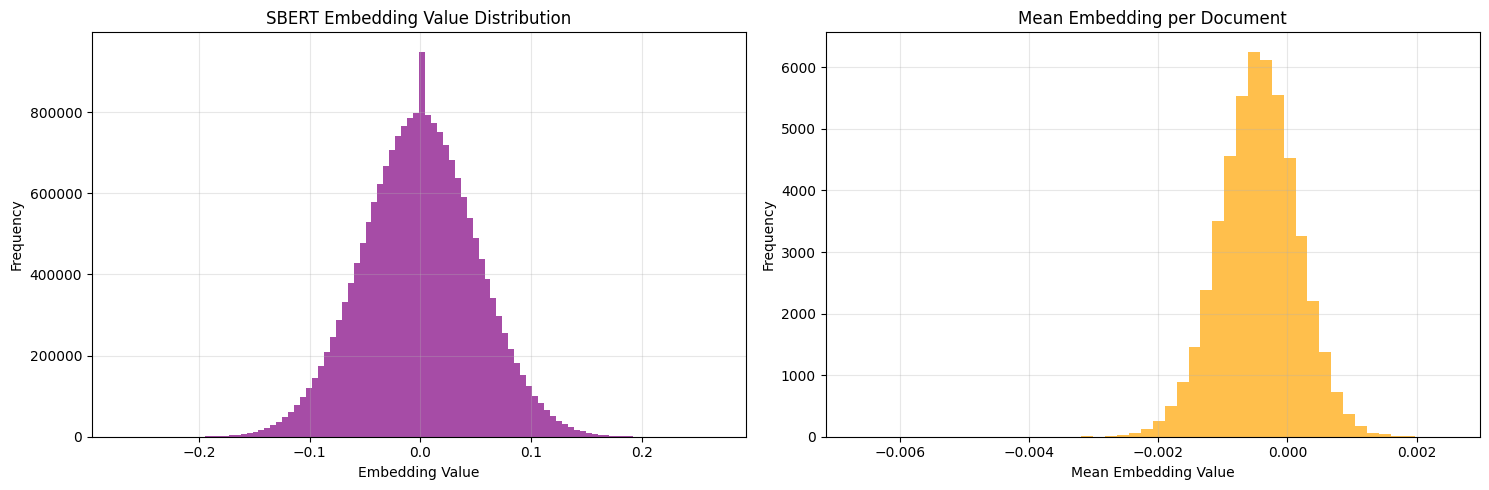


Statistics plotted!


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Embedding Statistics:\n")

# Basic stats
print(f"Shape: {embeddings.shape}")
print(f"Mean: {embeddings.mean():.4f}")
print(f"Std: {embeddings.std():.4f}")
print(f"Min: {embeddings.min():.4f}")
print(f"Max: {embeddings.max():.4f}")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(embeddings.flatten(), bins=100, alpha=0.7, color='purple')
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SBERT Embedding Value Distribution')
axes[0].grid(True, alpha=0.3)

# Mean embedding per document
mean_embeddings = embeddings.mean(axis=1)
axes[1].hist(mean_embeddings, bins=50, alpha=0.7, color='orange')
axes[1].set_xlabel('Mean Embedding Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Mean Embedding per Document')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistics plotted!")

Performing PCA on 1000 samples...
Explained variance: 6.54%


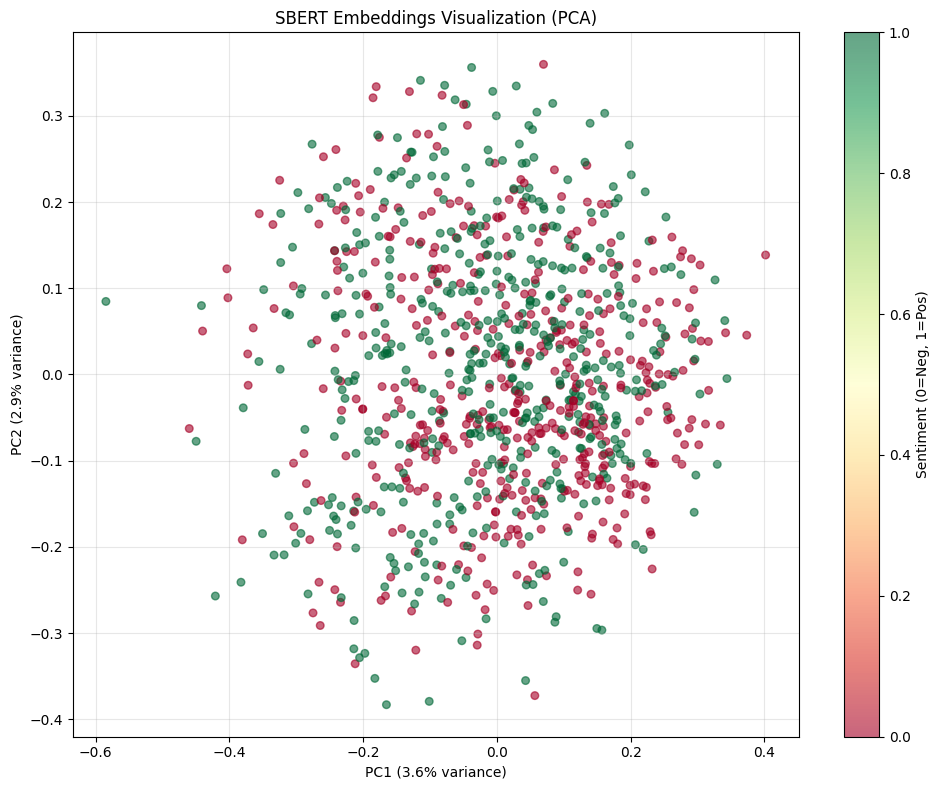


Visualization complete!
Note: SBERT embeddings should show better semantic clustering!


In [12]:
from sklearn.decomposition import PCA

# Sample for visualization
sample_size = 1000
indices = np.random.choice(len(embeddings), size=min(sample_size, len(embeddings)), replace=False)

sample_embeddings = embeddings[indices]
sample_labels = df['sentiment_label'].iloc[indices].values

# PCA reduction to 2D
print(f"Performing PCA on {len(sample_embeddings)} samples...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sample_embeddings)

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=sample_labels,
    cmap='RdYlGn',
    alpha=0.6,
    s=30
)
plt.colorbar(scatter, label='Sentiment (0=Neg, 1=Pos)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('SBERT Embeddings Visualization (PCA)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVisualization complete!")
print("Note: SBERT embeddings should show better semantic clustering!")

In [13]:
# Find most similar reviews to a query
print("Testing semantic similarity search:\n")

# Query review
query_idx = 0
query_text = df['review_text'].iloc[query_idx]
query_embedding = embeddings[query_idx]

print(f"Query review: '{query_text[:200]}...'")
print(f"Query sentiment: {['Negative', 'Positive'][df['sentiment_label'].iloc[query_idx]]}\n")

# Compute similarities
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity([query_embedding], embeddings)[0]

# Get top 5 most similar (excluding itself)
top_indices = np.argsort(similarities)[::-1][1:6]

print("Top 5 most similar reviews:")
print("="*80)
for i, idx in enumerate(top_indices, 1):
    similar_text = df['review_text'].iloc[idx]
    similar_label = df['sentiment_label'].iloc[idx]
    similarity = similarities[idx]

    print(f"\n{i}. Similarity: {similarity:.4f} | Sentiment: {['Neg', 'Pos'][similar_label]}")
    print(f"   Text: '{similar_text[:150]}...'")

print("\n" + "="*80)
print("SBERT captures semantic meaning, not just word overlap!")

Testing semantic similarity search:

Query review: 'Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters....'
Query sentiment: Negative

Top 5 most similar reviews:

1. Similarity: 0.6707 | Sentiment: Pos
   Text: 'How many movies are there that you can think of when you see a movie like this? I can't count them but it sure seemed like the movie makers were tryin...'

2. Similarity: 0.6588 | Sentiment: Pos
   Text: 'I work at a movie theater and every Thursday night we have an employee screening of one movie that comes out the next day...Today it was The Guardian....'

3. Similarity: 0.6568 | Sentiment: Pos
   Text: 'As others that have commented around the web... I'm a 130 pilot in the Coast Guard. Having said that, and being the skeptic I am, I went expecting the...'

4. Similarity: 0.6223 | Sentiment: Pos
   Text: 'I was looking forward t

In [14]:
print("\n" + "="*80)
print("SBERT vs BERT Comparison")
print("="*80)

comparison = {
    'Feature': [
        'Purpose',
        'Training',
        'Architecture',
        'Embedding Dimension',
        'Parameters',
        'Pooling Strategy',
        'Semantic Similarity',
        'Speed',
        'Use Case'
    ],
    'BERT': [
        'General NLP',
        'Masked LM + NSP',
        'Transformer encoder',
        '768 (base)',
        '110M (base)',
        '[CLS] token',
        'Not optimized',
        'Slower',
        'Classification, NER, QA'
    ],
    'SBERT (all-MiniLM-L6-v2)': [
        'Sentence embeddings',
        'Siamese/Triplet networks',
        'Transformer (6 layers)',
        '384',
        '22M',
        'Mean pooling',
        'Highly optimized',
        'Much faster',
        'Similarity, clustering, retrieval'
    ]
}

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("Key Advantages of SBERT:")
print("="*80)
print("1. 5x smaller (22M vs 110M parameters)")
print("2. Produces semantically meaningful embeddings")
print("3. Much faster for similarity tasks (no need to compare all pairs)")
print("4. Lower dimensional (384 vs 768) - saves memory")
print("5. Pre-trained on similarity tasks (NLI, STS)")
print("\nResult: SBERT is best for sentence embeddings & similarity tasks")


SBERT vs BERT Comparison
            Feature                    BERT          SBERT (all-MiniLM-L6-v2)
            Purpose             General NLP               Sentence embeddings
           Training         Masked LM + NSP          Siamese/Triplet networks
       Architecture     Transformer encoder            Transformer (6 layers)
Embedding Dimension              768 (base)                               384
         Parameters             110M (base)                               22M
   Pooling Strategy             [CLS] token                      Mean pooling
Semantic Similarity           Not optimized                  Highly optimized
              Speed                  Slower                       Much faster
           Use Case Classification, NER, QA Similarity, clustering, retrieval

Key Advantages of SBERT:
1. 5x smaller (22M vs 110M parameters)
2. Produces semantically meaningful embeddings
3. Much faster for similarity tasks (no need to compare all pairs)
4. Lower dimens

In [15]:
print("\n" + "="*80)
print("SBERT (SENTENCE-BERT) EMBEDDING EXTRACTION SUMMARY")
print("="*80)

print(f"\n Model: {MODEL_NAME}")
print(f" Architecture: Sentence-BERT (optimized for sentence embeddings)")
print(f" Embedding dimension: {embeddings.shape[1]} (smaller than BERT!)")
print(f" Total documents: {embeddings.shape[0]:,}")
print(f" Total size: {embeddings.nbytes / (1024**2):.2f} MB")
print(f" Parameters: Only 22M (5x smaller than BERT Base)")

print(f"\n Files saved:")
print(f"   {output_dir}/")
print(f"   ├── sbert_embeddings.npy  ({embeddings.shape})")
print(f"   ├── labels.npy            ({loaded_labels.shape})")
print(f"   └── metadata.pkl")

print(f"\n Usage:")
print(f"   These embeddings can be used with any classifier:")
print(f"   - Logistic Regression")
print(f"   - SVM")
print(f"   - Random Forest")
print(f"   - K-Means clustering")
print(f"   - Semantic search")

print(f"\n Load embeddings:")
print(f"   X = np.load('{embeddings_path}')")
print(f"   y = np.load('{labels_path}')")

print(f"\n Why SBERT:")
print(f"   - Optimized for semantic similarity")
print(f"   - Much smaller and faster than BERT")
print(f"   - Produces meaningful sentence embeddings")
print(f"   - Best for: similarity search, clustering, retrieval")
print(f"   - Lower dimensional embeddings (saves memory & computation)")

print("\n" + "="*80)
print(" SBERT embedding extraction complete!")
print("="*80)


SBERT (SENTENCE-BERT) EMBEDDING EXTRACTION SUMMARY

 Model: all-MiniLM-L6-v2
 Architecture: Sentence-BERT (optimized for sentence embeddings)
 Embedding dimension: 384 (smaller than BERT!)
 Total documents: 50,000
 Total size: 73.24 MB
 Parameters: Only 22M (5x smaller than BERT Base)

 Files saved:
   /content/drive/MyDrive/Shut up/models/sbert_embeddings/
   ├── sbert_embeddings.npy  ((50000, 384))
   ├── labels.npy            ((50000,))
   └── metadata.pkl

 Usage:
   These embeddings can be used with any classifier:
   - Logistic Regression
   - SVM
   - Random Forest
   - K-Means clustering
   - Semantic search

 Load embeddings:
   X = np.load('/content/drive/MyDrive/Shut up/models/sbert_embeddings/sbert_embeddings.npy')
   y = np.load('/content/drive/MyDrive/Shut up/models/sbert_embeddings/labels.npy')

 Why SBERT:
   - Optimized for semantic similarity
   - Much smaller and faster than BERT
   - Produces meaningful sentence embeddings
   - Best for: similarity search, clusteri